# Negative autoregulation (protein represses its own transcription)

### $$\dot{m} = k_{tx}\frac{1}{1 + \big(\frac{p}{K}\big)^{n}} - (\gamma_m+\mu)m$$
### $$\dot{p} =  k_{tl}m - (\gamma_p + \mu)p$$

#### Hyperparameters
##### $k_{tx} [mRNA · time^{−1}]$ — transcription rate.
##### $k_{tl} [(protein).mRNA · time^{−1}]$ - translation rate.
##### $γm[time−1]$ — mRNA decay rate
##### $γp[time−1]$ — protein decay rate
##### $μ [time−1]$ — growth/dilution rate (set 0 for non-growing cells or include to see how growth throttles levels)

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import mplhelv

In [7]:
def genex(t, mp, params):
    ktx, gammam, mu, ktl, gammap, K, n = params
    m, p = mp
    return [ktx*1/(1+(p/K)**n) - (gammam + mu)*m, ktl*m - (gammap + mu)*p]

In [17]:
time = (0, 10)

K=0.5 #(half-activation mid-range)
n=2
ktx=1
gammam=1
ktl=5
gammap=0.2
mu=0
m0=0 
p0=0
t0 = 0

In [24]:
G = (ktx*ktl)/((gammam+mu)*(gammap+mu))
def p_star(K, n):
    f = lambda p: p*(1 + (p/K)**n) - G
    return brentq(f, 0.0, G)           # bracket works: f(0)<0, f(G)>0

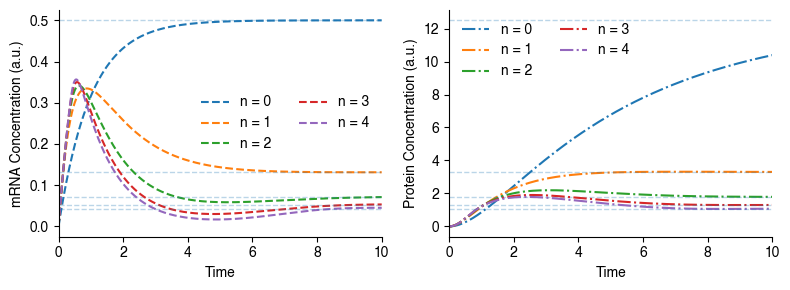

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for n in range(5):
    t0 = 0
    time = (0, 40)
    params = (ktx, gammam, mu, ktl, gammap, K, n)

    sol = solve_ivp(genex, time, [m0, p0], args=(params,),
                method='RK45', dense_output=True,
                rtol=1e-6, atol=1e-9, max_step=np.inf)
    t = np.linspace(*time, 4000)
    mdot, pdot = sol.sol(t)
    axs[0].plot(t, mdot, ls='--', label=f'n = {n}')
    axs[1].plot(t, pdot, ls='-.', label=f'n = {n}')
    p_ss = p_star(K, n)
    m_ss = (gammap+mu)/ktl * p_ss
    axs[0].axhline(m_ss, ls='--', lw=1, alpha=0.3)
    axs[1].axhline(p_ss, ls='--', lw=1, alpha=0.3)
    axs[1].set_ylabel("Protein Concentration (a.u.)")
    axs[0].set_ylabel("mRNA Concentration (a.u.)")
    axs[0].set_xlim(0, 10)
    axs[1].set_xlim(0, 10)
for ax in axs.flatten():
    ax.set_xlabel("Time")
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, ncol=2)
fig.tight_layout()

In [45]:
m_max = 0.4
p_max = 5
p_line = np.linspace(0.0, p_max, 400)
m_null = (ktx / (gammam + mu)) * (1.0 / (1.0 + (p_line / K)**n))

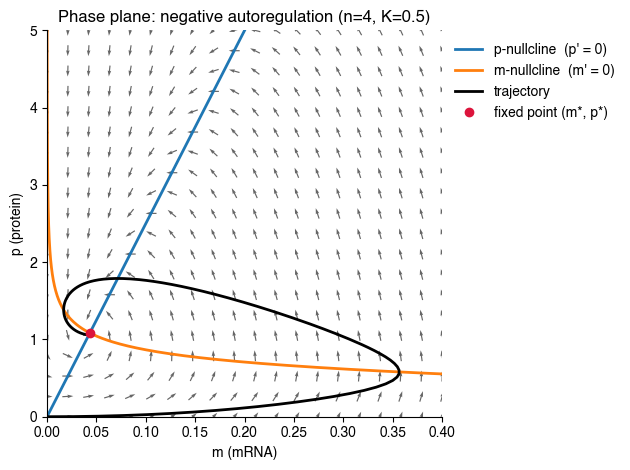

In [44]:
m_line = np.linspace(0.0, m_max, 400)
p_null = (ktl / (gammap + mu)) * m_line

Mm, Pp = np.meshgrid(
    np.linspace(0.0, m_max, 20),
    np.linspace(0.0, p_max, 20),
    indexing='xy'
)
DM = ktx / (1.0 + (Pp / K)**n) - (gammam + mu) * Mm
DP = ktl * Mm - (gammap + mu) * Pp
speed = np.hypot(DM, DP)
speed[speed == 0] = 1.0
DMn, DPn = DM / speed, DP / speed   # normalized arrows

t_span = (0.0, 40.0)
y0 = [0.0, 0.0]   # (m0, p0)
t_eval = np.linspace(*t_span, 1500)
sol = solve_ivp(genex, t_span, y0, args=(params,), method='RK45', t_eval=t_eval,
                rtol=1e-6, atol=1e-9)
m_traj, p_traj = sol.y

# --------- plot ----------
fig, ax = plt.subplots(figsize=(6.4, 4.8))

# vector field
ax.quiver(Mm, Pp, DMn, DPn, pivot='mid', linewidth=0.5, alpha=0.6)

# nullclines
ax.plot(m_line, p_null,  lw=2, label="p-nullcline  (p' = 0)")
ax.plot(m_null, p_line,  lw=2, label="m-nullcline  (m' = 0)")

def p_star_scalar(p):
    return p * (1.0 + (p / K)**n) - G

p_star_s = brentq(p_star_scalar, 0.0, G)
m_star = ((gammap + mu) / ktl) * p_star_s


# trajectory + fixed point
ax.plot(m_traj, p_traj, color='k', lw=2, label="trajectory")
ax.plot(m_star, p_star_s, 'o', color='crimson', label="fixed point (m*, p*)")

ax.set_xlim(0, m_max)
ax.set_ylim(0, p_max)
ax.set_xlabel("m (mRNA)")
ax.set_ylabel("p (protein)")
ax.set_title(f"Phase plane: negative autoregulation (n={n}, K={K})")
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False, bbox_to_anchor=(1, 1))
fig.tight_layout()
plt.show()

## Steady-state dose plot p\* vs K

In [68]:
K_min = 1
K_max = 200
K_line = np.linspace(K_min, K_max, 400)
n = 2

Text(0, 0.5, 'p*')

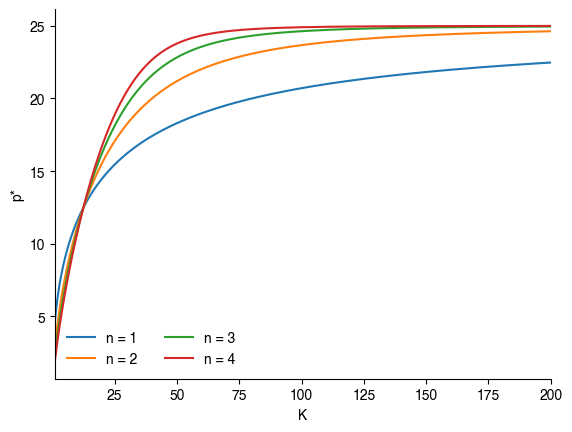

In [69]:
fig, axs = plt.subplots()
for n in range(1, 5):
    p_stars = []
    for K in K_line:
        p_star_s = p_star(K, n)
        p_stars.append(p_star_s)
    axs.plot(K_line, p_stars, label=f'n = {n}')
axs.legend()
axs.spines[["top", "right"]].set_visible(False)
axs.legend(frameon=False, ncol=2)
axs.set_xlim(K_min, K_max)
# axs.set_ylim(0,)
axs.set_xlabel("K")
axs.set_ylabel("p*")

## Growth–expression trade-off

In [70]:
def p_star(K, n, G):
    f = lambda p: p*(1 + (p/K)**n) - G
    return brentq(f, 0.0, G) 

2


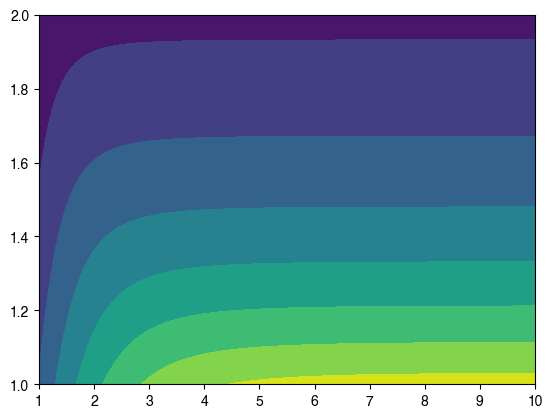

In [80]:
fig, axs = plt.subplots()
mu_min = 1
mu_max = 2
K_min = 1
K_max = 10
K_line = np.linspace(K_min, K_max, 400)
mu_line = np.linspace(mu_min, mu_max, 400)
p_sweep = []
for mu in mu_line:
    p_stars = []
    G = (ktx*ktl)/((gammam+mu)*(gammap+mu))
    for K in K_line:
        p_star_s = p_star(K, n, G)
        p_stars.append(p_star_s)
    p_sweep.append(p_stars)
p_sweep = np.array(p_sweep)
print(p_sweep.ndim)
axs.contourf(K_line, mu_line, p_sweep)
